In [ ]:
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from py import util

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_DIR = 'data'

# 1. Load the data

In [3]:
WEEKS = range(1,9)

In [4]:
games = util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, 'games.csv')))
games = games[games['week'].isin(WEEKS)].reset_index(drop=True)
game_ids = games['game_id'].unique()
games.head()

game_id  season  week  game_date game_time_eastern home_team_abbr  \
0  2022090800    2022     1   9/8/2022          20:20:00             LA   
1  2022091100    2022     1  9/11/2022          13:00:00            ATL   
2  2022091101    2022     1  9/11/2022          13:00:00            CAR   
3  2022091102    2022     1  9/11/2022          13:00:00            CHI   
4  2022091103    2022     1  9/11/2022          13:00:00            CIN   

  visitor_team_abbr  home_final_score  visitor_final_score  
0               BUF                10                   31  
1                NO                26                   27  
2               CLE                24                   26  
3                SF                19                   10  
4               PIT                20                   23

In [5]:
cols = ['game_id', 'play_id', 'play_description', 'quarter', 'down',
       'yards_to_go', 'possession_team', 'defensive_team', 'game_clock', 
       'pre_snap_home_score', 'pre_snap_visitor_score', 
       'absolute_yardline_number', 'pre_snap_home_team_win_probability',
       'pre_snap_visitor_team_win_probability', 'expected_points',
       'offense_formation', 'receiver_alignment', 'play_clock_at_snap',
       'rush_location_type',
       'yards_gained', 'home_team_win_probability_added',
       'visitor_team_win_probility_added', 'expected_points_added',
       'pff_run_concept_primary',
       'pff_pass_coverage', 'pff_man_zone']

plays = (
    util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, 'plays.csv')))
    .query('game_id.isin(@game_ids)')
    .query('pff_run_concept_primary.notnull() and ~pff_run_concept_primary.isin(["TRICK","UNDEFINED"])')
    .query('play_nullified_by_penalty == "N"')
    .query('yards_gained == pre_penalty_yards_gained')
    .query('qb_kneel == 0 and qb_sneak != True and qb_spike != True')
    .query('pass_result.isna() and is_dropback == False') # Designed runs only
    .query('pff_run_pass_option == 0')
    .query('dropback_type.isna()')
    .reset_index(drop=True)
    [cols]
)
plays.insert(0, 'game_play_id', plays['game_id'].astype(str) + '_' + plays['play_id'].astype(str))

game_play_ids = plays['game_play_id'].unique()

print(f'Number of non-RPO run plays: {len(game_play_ids)}')
print(plays.pff_run_concept_primary.value_counts())
plays.head()

Number of non-RPO run plays: 3975
OUTSIDE ZONE    1261
MAN              797
INSIDE ZONE      715
PULL LEAD        356
POWER            354
COUNTER          285
DRAW              95
TRAP              81
FB RUN            31
Name: pff_run_concept_primary, dtype: int64


game_play_id     game_id  play_id  \
0  2022100205_2314  2022100205     2314   
1  2022102306_3240  2022102306     3240   
2  2022100212_2463  2022100212     2463   
3  2022101601_2344  2022101601     2344   
4  2022092509_2694  2022092509     2694   

                                    play_description  quarter  down  \
0  (14:15) Ja.Williams up the middle to DET 32 fo...        3     2   
1  (12:55) (Shotgun) A.Dillon left tackle to WAS ...        4     2   
2  (3:18) J.Herron reported in as eligible.  J.Ja...        3     1   
3  (10:13) (No Huddle) K.Hunt right tackle to CLV...        3     1   
4  (8:21) T.Etienne up the middle to LAC 45 for -...        3     1   

   yards_to_go possession_team defensive_team game_clock  pre_snap_home_score  \
0            6             DET            SEA      14:15                   15   
1           10              GB            WAS      12:55                   20   
2            1              LV            DEN      03:18                   19   
3           10             CLE             NE      10:13                    6   
4            5             JAX            LAC      08:21                   10   

   pre_snap_visitor_score  absolute_yardline_number  \
0                      31                        39   
1                      14                        64   
2                      16                        11   
3                      17                        74   
4                      23                        54   

   pre_snap_home_team_win_probability  pre_snap_visitor_team_win_probability  \
0                            0.138289                               0.861711   
1                            0.630746                               0.369254   
2                            0.824414                               0.175586   
3                            0.229286                               0.770714   
4                            0.108009                               0.891991   

   expected_points offense_formation receiver_alignment  play_clock_at_snap  \
0         1.066931        SINGLEBACK                3x1                15.0   
1         2.416086           SHOTGUN                3x1                 4.0   
2         6.442386             JUMBO                1x1                 6.0   
3         2.069337        SINGLEBACK                2x2                18.0   
4         3.489420        SINGLEBACK                3x1                19.0   

  rush_location_type  yards_gained  home_team_win_probability_added  \
0       INSIDE_RIGHT             3                        -0.024210   
1        INSIDE_LEFT             0                         0.053308   
2       OUTSIDE_LEFT            -2                        -0.017039   
3      OUTSIDE_RIGHT             1                         0.000048   
4        INSIDE_LEFT            -1                        -0.001843   

   visitor_team_win_probility_added  expected_points_added  \
0                          0.024210              -0.442517   
1                         -0.053308              -0.962012   
2                          0.017039              -0.822176   
3                         -0.000048              -0.467615   
4                          0.001843              -0.587710   

  pff_run_concept_primary pff_pass_coverage pff_man_zone  
0                     MAN      Cover 6-Left         Zone  
1               PULL LEAD     Cover-6 Right         Zone  
2                     MAN         Goal Line        Other  
3            OUTSIDE ZONE           Cover-3         Zone  
4                     MAN      Cover 6-Left         Zone

In [6]:
tracking = pd.DataFrame()
for i in tqdm(WEEKS, desc='Loading tracking data', unit='file'):
    data = util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, f'tracking_week_{i}.csv')))
    data.insert(
        0, 
        'game_play_id', 
        data['game_id'].astype(str) + '_' + data['play_id'].astype(str)
    )
    data = data.query('game_play_id in @game_play_ids').drop(columns=['jersey_number'])
    tracking = pd.concat([
        tracking,
        data
    ], ignore_index=True)

del data

tracking, plays = util.standardize_direction(tracking, plays)

tracking.head()

Loading tracking data: 100%|██████████| 8/8 [01:33<00:00, 11.68s/file]


game_play_id     game_id  play_id   nfl_id    display_name  frame_id  \
0  2022091200_64  2022091200       64  35459.0  Kareem Jackson         1   
1  2022091200_64  2022091200       64  35459.0  Kareem Jackson         2   
2  2022091200_64  2022091200       64  35459.0  Kareem Jackson         3   
3  2022091200_64  2022091200       64  35459.0  Kareem Jackson         4   
4  2022091200_64  2022091200       64  35459.0  Kareem Jackson         5   

    frame_type                   time club play_direction      x      y     s  \
0  BEFORE_SNAP  2022-09-13 00:16:03.5  DEN          right  24.75  51.06  0.72   
1  BEFORE_SNAP  2022-09-13 00:16:03.6  DEN          right  24.73  51.13  0.71   
2  BEFORE_SNAP  2022-09-13 00:16:03.7  DEN          right  24.71  51.20  0.69   
3  BEFORE_SNAP  2022-09-13 00:16:03.8  DEN          right  24.68  51.26  0.67   
4  BEFORE_SNAP  2022-09-13 00:16:03.9  DEN          right  24.65  51.32  0.65   

      a   dis       o     dir                 event  
0  0.37  0.07  293.83  111.66  huddle_break_offense  
1  0.36  0.07  294.59  108.79                   NaN  
2  0.23  0.07  295.55  110.10                   NaN  
3  0.22  0.07  295.55  112.02                   NaN  
4  0.34  0.07  294.26  117.17                   NaN

In [7]:
# only include tracking data for plays at or after the ball snap
ball_snap_frames = (
    tracking[tracking['event'] == 'ball_snap']
    .groupby('game_play_id')['frame_id']
    .min()
    .rename('ball_snap_frame_id')
)
tracking = tracking.merge(ball_snap_frames, on='game_play_id', how='left')
tracking = tracking[tracking['frame_id'] >= tracking['ball_snap_frame_id']].reset_index(drop=True)
tracking = tracking.drop(columns=['ball_snap_frame_id'])

In [8]:
players = util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, 'players.csv')))
players.head()

nfl_id height  weight  birth_date    college_name position    display_name
0   25511    6-4     225  1977-08-03        Michigan       QB       Tom Brady
1   29550    6-4     328  1982-01-22        Arkansas        T    Jason Peters
2   29851    6-2     225  1983-12-02      California       QB   Aaron Rodgers
3   30842    6-6     267  1984-05-19            UCLA       TE  Marcedes Lewis
4   33084    6-4     217  1985-05-17  Boston College       QB       Matt Ryan

In [9]:
player_play = util.uncamelcase_columns(pd.read_csv(join(DATA_DIR, 'player_play.csv')))
player_play.insert(0, 'game_play_id', player_play['game_id'].astype(str) + '_' + player_play['play_id'].astype(str))
player_play = player_play.query('game_play_id in @game_play_ids').reset_index(drop=True)
player_play.head()

game_play_id     game_id  play_id  nfl_id team_abbr  had_rush_attempt  \
0  2022090800_101  2022090800      101   35472       BUF                 0   
1  2022090800_101  2022090800      101   42392       BUF                 0   
2  2022090800_101  2022090800      101   42818       BUF                 0   
3  2022090800_101  2022090800      101   44875       BUF                 0   
4  2022090800_101  2022090800      101   46076       BUF                 0   

   rushing_yards  had_dropback  passing_yards  sack_yards_as_offense  \
0              0             0              0                      0   
1              0             0              0                      0   
2              0             0              0                      0   
3              0             0              0                      0   
4              0             0              0                      0   

   had_pass_reception  receiving_yards  was_targetted_receiver  \
0                   0                0                       0   
1                   0                0                       0   
2                   0                0                       0   
3                   0                0                       0   
4                   0                0                       0   

   yardage_gained_after_the_catch  fumbles  fumble_lost  fumble_out_of_bounds  \
0                               0        0            0                     0   
1                               0        0            0                     0   
2                               0        0            0                     0   
3                               0        0            0                     0   
4                               0        0            0                     0   

   assisted_tackle  forced_fumble_as_defense  half_sack_yards_as_defense  \
0                0                         0                           0   
1                0                         0                           0   
2                0                         0                           0   
3                0                         0                           0   
4                0                         0                           0   

   pass_defensed  quarterback_hit  sack_yards_as_defense  safety_as_defense  \
0              0                0                      0                  0   
1              0                0                      0                  0   
2              0                0                      0                  0   
3              0                0                      0                  0   
4              0                0                      0                  0   

   solo_tackle  tackle_assist  tackle_for_a_loss  tackle_for_a_loss_yardage  \
0            0              0                  0                          0   
1            0              0                  0                          0   
2            0              0                  0                          0   
3            0              0                  0                          0   
4            0              0                  0                          0   

   had_interception  interception_yards  fumble_recoveries  \
0                 0                   0                  0   
1                 0                   0                  0   
2                 0                   0                  0   
3                 0                   0                  0   
4                 0                   0                  0   

   fumble_recovery_yards  penalty_yards penalty_names  \
0                      0              0           NaN   
1                      0              0           NaN   
2                      0              0           NaN   
3                      0              0           NaN   
4                      0              0           NaN   

   was_initial_pass_rusher  caused_pressure  time_to_pressure_as_pass_rusher  \
0               

# 2. Filter the plays
- remove plays w/o exactly one ball carrier
- remove plays without the 5 standard offensive linemane (LT, LG, C, RG, LT)

In [10]:
# Find distance from each player to the ball
ball_coords = (
    tracking.query('club=="football"')
    [['game_play_id', 'frame_id', 'x', 'y']]
    .rename(columns={'x': 'ball_x', 'y': 'ball_y'})
)
cols = ['euclidean_dist_to_ball', 'ball_x', 'ball_y', 'lateral_distance_to_ball', 'vertical_dist_to_ball']
for col in cols:
    if col in tracking.columns:
        tracking = tracking.drop(columns=[col])
tracking = tracking.merge(ball_coords, on=['game_play_id', 'frame_id'], how='left')
tracking['euclidean_dist_to_ball'] = (
    (tracking['x'] - tracking['ball_x']) ** 2 +
    (tracking['y'] - tracking['ball_y']) ** 2
) ** 0.5
tracking['euclidean_dist_to_ball'] = tracking['euclidean_dist_to_ball'].round(2)
tracking['lateral_distance_to_ball'] = (
    tracking['x'] - tracking['ball_x']
).round(2)
tracking['vertical_dist_to_ball'] = (
    tracking['y'] - tracking['ball_y']
).round(2)
tracking.drop(columns=['ball_x', 'ball_y'], inplace=True)
del ball_coords


# Label the ball carrier
cols = ['is_ball_carrier']
for col in cols:
    if col in tracking.columns:
        tracking = tracking.drop(columns=[col])
tracking = tracking.merge(
    player_play[['game_play_id', 'nfl_id', 'had_rush_attempt']]
    .query('had_rush_attempt == 1')
    .rename(columns={'had_rush_attempt': 'is_ball_carrier'}),
    on=['game_play_id', 'nfl_id'],
    how='left'
)
tracking['is_ball_carrier'] = tracking['is_ball_carrier'].fillna(0).astype(int)
# drop plays with multiple ball carriers or no ball carrier
n_ball_carriers = (
    tracking.query('frame_type=="SNAP"').groupby(['game_play_id'])['is_ball_carrier']
    .sum()
    .reset_index()
    .rename(columns={'is_ball_carrier': 'n_ball_carriers'})
)
tracking = tracking.merge(n_ball_carriers, on='game_play_id', how='left')
tracking = tracking.query('n_ball_carriers == 1').reset_index(drop=True).drop(columns=['n_ball_carriers'])
game_play_ids = tracking['game_play_id'].unique()
game_ids = tracking['game_id'].unique()
games = games.query('game_id in @game_ids').reset_index(drop=True)
plays = plays.query('game_play_id in @game_play_ids').reset_index(drop=True)
player_play = player_play.query('game_play_id in @game_play_ids').reset_index(drop=True)


# Join roster assigned positions
cols = ['roster_position']
for col in cols:
    if col in tracking.columns:
        tracking = tracking.drop(columns=[col])
tracking = tracking.merge(
    players[['nfl_id', 'position']],
    on='nfl_id',
    how='left'
).rename(columns={'position': 'roster_position'})
tracking['roster_position'] = np.where(
    tracking.display_name == "Taysom Hill",
    "TE",
    tracking.roster_position
)

tracking.head()

game_play_id     game_id  play_id   nfl_id    display_name  frame_id  \
0  2022091200_64  2022091200       64  35459.0  Kareem Jackson       114   
1  2022091200_64  2022091200       64  35459.0  Kareem Jackson       115   
2  2022091200_64  2022091200       64  35459.0  Kareem Jackson       116   
3  2022091200_64  2022091200       64  35459.0  Kareem Jackson       117   
4  2022091200_64  2022091200       64  35459.0  Kareem Jackson       118   

   frame_type                   time club play_direction      x      y     s  \
0        SNAP  2022-09-13 00:16:14.8  DEN          right  23.87  50.29  1.13   
1  AFTER_SNAP  2022-09-13 00:16:14.9  DEN          right  23.96  50.39  1.37   
2  AFTER_SNAP    2022-09-13 00:16:15  DEN          right  24.06  50.52  1.65   
3  AFTER_SNAP  2022-09-13 00:16:15.1  DEN          right  24.18  50.67  1.99   
4  AFTER_SNAP  2022-09-13 00:16:15.2  DEN          right  24.32  50.85  2.32   

      a   dis       o    dir      event  euclidean_dist_to_ball  \
0  1.62  0.11  299.94  46.84  ball_snap                   12.91   
1  1.61  0.13  299.94  48.81        NaN                   13.31   
2  1.76  0.16  301.53  50.88        NaN                   13.74   
3  1.94  0.20  304.34  51.68        NaN                   14.23   
4  2.03  0.23  308.28  52.75        NaN                   14.82   

   lateral_distance_to_ball  vertical_dist_to_ball  is_ball_carrier  \
0                     -5.32                  11.76                0   
1                     -5.24                  12.23                0   
2                     -5.22                  12.71                0   
3                     -5.27                  13.22                0   
4                     -5.39                  13.80                0   

  roster_position  
0              SS  
1              SS  
2              SS  
3              SS  
4              SS

In [11]:
# Drop plays without exactly 5 offensive linemen
offensive_line = ['T','G','C']
o_line = tracking[
    tracking['roster_position'].isin(offensive_line) &
    (tracking.frame_type == "SNAP")
]
o_line = o_line.groupby('game_play_id').size().reset_index(name='count')
o_line = o_line[o_line['count'] != 5]
drop_gid = o_line.game_play_id.unique().tolist()


print(f"Dropping {len(drop_gid)} plays without exactly 5 offensive linemen out of "
      "{len(tracking.game_play_id.unique())} total plays")
tracking = tracking[~tracking.game_play_id.isin(drop_gid)]
plays = plays[~plays.game_play_id.isin(drop_gid)]
player_play = player_play[~player_play.game_play_id.isin(drop_gid)]
games = games[games.game_id.isin(plays.game_id.unique())]

Dropping 276 plays without exactly 5 offensive linemen out of {len(tracking.game_play_id.unique())} total plays


In [12]:
# Label Offensive line positions

cols = ['game_play_id','frame_id','frame_type','nfl_id','roster_position','display_name','x','y','event']
lineman_and_qb = tracking[
    (tracking.frame_type == 'SNAP') & 
    tracking.roster_position.isin(offensive_line + ['QB'])
][cols]

lineman_and_qb['farthest_forward_lineman'] = (
    lineman_and_qb
    .query('roster_position != "QB"')
    .groupby('game_play_id')
    .y.transform('max')
)
lineman_and_qb['farthest_forward_lineman'] = np.where(
    lineman_and_qb.farthest_forward_lineman == lineman_and_qb.y,
    True,
    False
)

ball = (
    tracking.query('club == "football" and frame_type == "SNAP"')
    [['game_play_id','frame_id','x','y']]
    .rename(columns={'x': 'x_ball', 'y': 'y_ball'})
)
lineman_and_qb = lineman_and_qb.merge(ball, on='game_play_id')
lineman_and_qb['delta_ball'] = np.sqrt(
    (lineman_and_qb.x - lineman_and_qb.x_ball)**2 + 
    (lineman_and_qb.y - lineman_and_qb.y_ball)**2
)
lineman_and_qb['closest_to_ball'] = (
    lineman_and_qb
    .query('roster_position != "QB"')
    .groupby('game_play_id')
    .delta_ball.transform('min')
)
lineman_and_qb['closest_to_ball'] = np.where(
    lineman_and_qb.closest_to_ball == lineman_and_qb.delta_ball,
    True,
    False
)

# number the lineman from left to right by x position
lineman_and_qb = lineman_and_qb.sort_values(['game_play_id','x'])
position_map = {
    0: 'LT',
    1: 'LG',
    2: 'C',
    3: 'RG',
    4: 'RT'
}
lineman_and_qb.loc[lineman_and_qb.roster_position.isin(['T','C','G']),'position_by_loc'] = (
    lineman_and_qb
    .query('roster_position != "QB"')
    .groupby('game_play_id')
    .cumcount()
).replace(position_map)    

lineman_and_qb['is_center'] = np.where(
    (lineman_and_qb.closest_to_ball & (lineman_and_qb.position_by_loc=="C")), #| 
    True,
    False
)

plays_without_balanced_offensive_line = (
    lineman_and_qb
    .groupby('game_play_id')
    .is_center.sum().reset_index()
    .query('is_center != 1')
    .game_play_id.values.tolist()
)
if len(plays_without_balanced_offensive_line) != 0:
    print(f"Dropping {len(plays_without_balanced_offensive_line)} plays without a balanced offensive line.")
    print(plays_without_balanced_offensive_line)
    tracking = tracking[~tracking.game_play_id.isin(plays_without_balanced_offensive_line)]
    plays = plays[~plays.game_play_id.isin(plays_without_balanced_offensive_line)]
    player_play = player_play[~player_play.game_play_id.isin(plays_without_balanced_offensive_line)]
    games = games[games.game_id.isin(plays.game_id.unique())]
else:
    print("All plays have a balanced offensive line.")

# Create a new column for the position of the player based on the location of the player
tracking = (
    tracking
    .merge(
        lineman_and_qb[['game_play_id','nfl_id','position_by_loc']].drop_duplicates(),
        on=['game_play_id','nfl_id'],
        how='left'
    )
)
tracking['position_by_loc'] = np.where(
    tracking.position_by_loc.isna(),
    tracking.roster_position,
    tracking.position_by_loc
)

Dropping 71 plays without a balanced offensive line.
['2022091101_2386', '2022091102_322', '2022091102_3981', '2022091102_467', '2022091104_2269', '2022091104_4410', '2022091104_999', '2022091105_1309', '2022091105_1351', '2022091105_294', '2022091105_3366', '2022091105_4512', '2022091108_1089', '2022091108_2724', '2022091109_1636', '2022091109_3463', '2022091109_656', '2022091111_2901', '2022091803_2300', '2022091804_3308', '2022091806_253', '2022091808_2420', '2022092500_1074', '2022092505_1347', '2022092505_2019', '2022092506_3644', '2022092507_1254', '2022092509_1716', '2022092900_904', '2022100201_2798', '2022100204_3385', '2022100209_2869', '2022100209_501', '2022100209_596', '2022100210_4013', '2022100210_488', '2022100213_3913', '2022100902_1550', '2022100902_3966', '2022100903_1614', '2022100903_2758', '2022100906_717', '2022100908_106', '2022100912_3446', '2022101603_3535', '2022101603_3601', '2022101603_4087', '2022101606_1017', '2022101606_2096', '2022101606_56', '202210160

In [13]:
tracking.roster_position.unique()

array(['SS', 'QB', 'G', 'CB', 'OLB', 'WR', 'DE', 'ILB', 'FS', 'C', 'NT',
       'RB', 'TE', 'T', nan, 'DT', 'MLB', 'FB', 'LB', 'DB'], dtype=object)

In [14]:
offense_positions = ['QB', 'RB', 'FB', 'WR', 'TE', 'G', 'C', 'T']
defense_positions = ['DE', 'DT', 'NT', 'OLB', 'ILB', 'MLB', 'CB', 'SS', 'FS', 'DB', 'LB']

if tracking.roster_position.nunique() != len(offense_positions + defense_positions):
    raise Exception("There are players with positions not in the offense or defense position lists.")

tracking['offense'] = np.where(
    tracking.roster_position.isin(offense_positions),
    1,
    0
)

# 3.  Identify players that are an extension of the core 5 olineman

In [15]:
cols = ['y_min_oline_left', 'y_min_oline_right', 'extra_on_oline', 
        'extra_oline_box_left', 'extra_oline_box_right', 'oline_box_left', 
        'oline_box_right', 'center_x_at_ball_snap']
for col in cols:
    if col in tracking.columns:
        tracking = tracking.drop(columns=[col])

oline_box_at_snap = (
    tracking
    .query('position_by_loc in ["LT","RT"] and frame_type == "SNAP"')
    [['game_play_id','position_by_loc','x']]
)

# Add oline_box_left (at the snap)
tracking = (
    tracking
    .merge(
        (
            oline_box_at_snap
            .query('position_by_loc=="LT"')
            [['game_play_id','x']]
            .rename(columns={'x':'oline_box_left'})
        ), 
        on='game_play_id', 
        how='left'
    )
)

# Add oline_box_right (at the snap)
tracking = (
    tracking
    .merge(
        (
            oline_box_at_snap
            .query('position_by_loc=="RT"')
            [['game_play_id','x']]
            .rename(columns={'x':'oline_box_right'})
        ),
        on='game_play_id',
        how='left'
    )
)

# Add center_x_at_ball_snap
tracking = (
    tracking
    .merge(
        (
            tracking
            .query('position_by_loc == "C" and frame_type == "SNAP"')
            .rename(columns={'x':'center_x_at_ball_snap'})
            [['game_play_id','center_x_at_ball_snap']]
            .drop_duplicates()
        ),
        on='game_play_id',
        how='left'
    )
)

extra_on_oline = tracking.query('frame_type == "SNAP"')
y_min_oline_left = extra_on_oline.query('position_by_loc.isin(["LT","LG","C"])').groupby('game_play_id').y.min().reset_index()
y_min_oline_right = extra_on_oline.query('position_by_loc.isin(["RT","RG","C"])').groupby('game_play_id').y.min().reset_index()
extra_on_oline = extra_on_oline.merge(y_min_oline_left, on='game_play_id', suffixes=('','_min_oline_left'))
extra_on_oline = extra_on_oline.merge(y_min_oline_right, on='game_play_id', suffixes=('','_min_oline_right'))

extra_on_oline = extra_on_oline[extra_on_oline['offense'] == 1]
left_condition = (
    (extra_on_oline['x'] < extra_on_oline['oline_box_left']) & 
    (extra_on_oline['x'] > extra_on_oline['oline_box_left'] - 2) & 
    (extra_on_oline['y'] > extra_on_oline['y_min_oline_left'] - 0.1)
)
right_condition = (
    (extra_on_oline['x'] > extra_on_oline['oline_box_right']) & 
    (extra_on_oline['x'] < extra_on_oline['oline_box_right'] + 2) & 
    (extra_on_oline['y'] > extra_on_oline['y_min_oline_right'] - 0.1)
)
extra_on_oline = extra_on_oline[left_condition | right_condition]
extra_on_oline = extra_on_oline.drop_duplicates()[['game_play_id', 'nfl_id', 'x', 'y_min_oline_left', 
                                                  'y_min_oline_right', 'oline_box_left', 'oline_box_right']]

extra_on_oline['extra_on_oline'] = True
extra_on_oline['extra_oline_box_left'] = np.where(
    extra_on_oline['x'] < extra_on_oline['oline_box_left'],
    extra_on_oline['x'],
    None
)

extra_on_oline['extra_on_oline'] = True
extra_on_oline['extra_oline_box_left'] = np.where(
    extra_on_oline['x'] < extra_on_oline['oline_box_left'],
    extra_on_oline['x'],
    None
)
extra_on_oline['extra_oline_box_right'] = np.where(
    extra_on_oline['x'] > extra_on_oline['oline_box_right'],
    extra_on_oline['x'],
    None
)

# Merge extra oline data to the tracking data
if 'extra_on_oline' in tracking.columns:
    tracking.drop(columns='extra_on_oline', inplace=True)
if 'extra_oline_box_left' in tracking.columns:
    tracking.drop(columns='extra_oline_box_left', inplace=True)
if 'extra_oline_box_right' in tracking.columns:
    tracking.drop(columns='extra_oline_box_right', inplace=True)
if 'y_min_oline_left' in tracking.columns:
    tracking.drop(columns='y_min_oline_left', inplace=True)
if 'y_min_oline_right' in tracking.columns:
    tracking.drop(columns='y_min_oline_right', inplace=True)
tracking = tracking.merge(
    extra_on_oline[['game_play_id','nfl_id','y_min_oline_left','y_min_oline_right',
                    'extra_on_oline','extra_oline_box_left','extra_oline_box_right']],
    on=['game_play_id','nfl_id'], 
    how='left'
)
tracking['extra_oline_box_left'] = tracking.groupby('game_play_id')['extra_oline_box_left'].transform('max')
tracking['extra_oline_box_right'] = tracking.groupby('game_play_id')['extra_oline_box_right'].transform('max')
tracking['extra_oline_box_left'] = tracking['extra_oline_box_left'].fillna(tracking['oline_box_left'])
tracking['extra_oline_box_right'] = tracking['extra_oline_box_right'].fillna(tracking['oline_box_right'])
tracking['extra_on_oline'] = tracking['extra_on_oline'].fillna(False)

# Repeat the process for extra oline outside of the additional oline box
extra_on_oline = tracking.query('extra_on_oline and frame_type == "SNAP"')
extra_on_oline = extra_on_oline.query(
    'offense and ' +\
    '((~extra_oline_box_left.isna() and x < extra_oline_box_left and x > extra_oline_box_left - 2 and y > y_min_oline_left - 0.1) or ' +\
    ' (~extra_oline_box_right.isna() and x > extra_oline_box_right and x < extra_oline_box_right + 2 and y > y_min_oline_right - 0.1))',
    engine='python'
).drop_duplicates()[['game_play_id','nfl_id','x','y_min_oline_left','y_min_oline_right','extra_oline_box_left','extra_oline_box_right']]

extra_on_oline['extra_on_oline'] = True
extra_on_oline['extra_oline_box_left'] = np.where(
    extra_on_oline['x'] < extra_on_oline['extra_oline_box_left'],
    extra_on_oline['x'],
    None
)
extra_on_oline['extra_oline_box_right'] = np.where(
    extra_on_oline['x'] > extra_on_oline['extra_oline_box_right'],
    extra_on_oline['x'],
    None
)

if not extra_on_oline.empty:
    tracking = tracking.merge(
        extra_on_oline[['game_play_id','nfl_id',
                        'extra_on_oline','extra_oline_box_left','extra_oline_box_right']],
        on=['game_play_id','nfl_id'], 
        how='left',
        suffixes=('','_x')
    )

    tracking['extra_oline_box_left_x'] = tracking.groupby('game_play_id')['extra_oline_box_left_x'].transform('max')
    tracking['extra_oline_box_right_x'] = tracking.groupby('game_play_id')['extra_oline_box_right_x'].transform('max')
    tracking['extra_on_oline_x'] = tracking['extra_on_oline_x'].fillna(False)

    tracking['extra_on_oline'] = tracking['extra_on_oline'] | tracking['extra_on_oline_x']
    tracking['extra_oline_box_left'] = tracking['extra_oline_box_left'].fillna(tracking['extra_oline_box_left_x'])
    tracking['extra_oline_box_right'] = tracking['extra_oline_box_right'].fillna(tracking['extra_oline_box_right_x'])

    tracking.drop(columns=['extra_on_oline_x','extra_oline_box_left_x','extra_oline_box_right_x'], inplace=True)

In [16]:
drop_col = ['extra_oline_box_left','extra_oline_box_right', 'y_min_oline_right', 
            'y_min_oline_left', 'oline_box_left', 'oline_box_right', 'center_x_at_ball_snap']

tracking.drop(columns=drop_col, inplace=True)

In [17]:
tracking['is_part_of_oline'] = np.where(
    tracking['position_by_loc'].isin(['LT','LG','C','RG','RT']) | tracking['extra_on_oline'],
    True,
    False
)

# 4. Filter down to relevant frames
Relevant frames are those where the oline's blocking influences the ball carriers ability to gain yards. For this, we assume that it is plays where the rb has not passed beyond the offensive line. Additionally, the first second of frames post-snap are removed to allow for the run play to develop.

Filtering to frames where RB is behind or within the oline:
1. if rb is laterally outside the oline box for more than 2 continuous seconds, filter frames out.
2. rb passes ahead of all onlineman, filter frames out.
3. rb breaks through front of oline convex hull (rb must enter and then exist for at least .5 seconds)

#### Visualize when a RB breaks through the convex hull of the offensive line group

In [18]:
from shapely import MultiPoint, Point
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

frames_per_second = 10
outside_threshold = .5 * frames_per_second  # 2 seconds

game_play_id = '2022091200_741'

df = tracking.query('game_play_id == @game_play_id').copy()
df.head()

frame_ids = df['frame_id'].unique()
frame_ids.sort()
yardline = plays.query('game_play_id == @game_play_id').absolute_yardline_number.values[0]

rb_outside_counter = 0
rb_was_inside = False
broke_frame = None

# Precompute RB inside/outside status for each frame
rb_status = []
for frame_id in frame_ids:
    frame_df = df[df['frame_id'] == frame_id]
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    if len(points) >= 3 and not rb.empty:
        hull = MultiPoint(points).convex_hull
        rb_point = Point(rb.iloc[0]['x'], rb.iloc[0]['y'])
        inside = hull.contains(rb_point)
    else:
        inside = False
    rb_status.append(inside)

for i, inside in enumerate(rb_status):
    if inside:
        rb_outside_counter = 0
        rb_was_inside = True
        broke_frame = None
    else:
        if rb_was_inside:
            if rb_outside_counter == 0:
                left_frame = frame_ids[i]
            rb_outside_counter += 1
            if rb_outside_counter == outside_threshold:
                broke_frame = left_frame
                print(f"RB broke past the oline at frame {broke_frame}")
                break

fig, ax = plt.subplots(figsize=(8, 8))

def update(frame_id):
    ax.clear()
    frame_df = df[df['frame_id'] == frame_id]
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    if len(points) >= 3:
        convex_hull = MultiPoint(points).convex_hull
        x, y = convex_hull.exterior.xy
        ax.plot(x, y, color='blue', linewidth=2, label='OLine Group')
        # Highlight RB if outside hull after breaking
        if broke_frame is not None and frame_id >= broke_frame and not convex_hull.contains(Point(rb.iloc[0]['x'], rb.iloc[0]['y'])):
            ax.scatter(rb['x'], rb['y'], label='RB (broke past oline)', s=100, color='orange', edgecolor='black', zorder=5)
    # Plot players
    oline = frame_df[frame_df['is_part_of_oline']]
    ax.scatter(oline['x'], oline['y'], label='oline', s=50, color='green')
    if rb.shape[0] > 0:
        ax.scatter(rb['x'], rb['y'], label='ball carrier', s=50, color='purple')
    defense = frame_df[(frame_df['offense'] == 0) & (frame_df['club'] != 'football')]
    ax.scatter(defense['x'], defense['y'], label='defense', s=50, color='red')
    ax.hlines(yardline, 0, 53.3, color='blue', linestyle='--', label='Yard Line')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, 53.3)
    ax.set_ylim(df['y'].min() - 1, df['y'].max() + 1)
    title = f'Convex Hull of Offensive Linemen\nFrame {frame_id}'
    if broke_frame is not None and frame_id >= broke_frame:
        title += " (RB broke past oline)"
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(.8, 1.5), loc='upper left')

ani = FuncAnimation(fig, update, frames=frame_ids, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())

RB broke past the oline at frame 73


#### Calculate the RB "breakthrough" frame, remove all frames after that.

In [19]:
from shapely import MultiPoint, Point

frames_per_second = 10
outside_threshold = 2 * frames_per_second  # 2 seconds

breakthrough_dict = {}

cols = ['game_play_id', 'frame_id', 'x', 'y', 'is_ball_carrier', 'is_part_of_oline']

for game_play_id, play_df in tqdm(
        iterable=tracking[cols].groupby('game_play_id'), 
        total=len(tracking['game_play_id'].unique()), 
        desc='Finding Breakthroughs'
    ):

    play_df = play_df.sort_values('frame_id')
    frame_ids = play_df['frame_id'].unique()
    rb_outside_counter = 0
    rb_was_inside = False
    breakthrough_frame = None

    # Precompute RB inside/outside status for each frame (convex hull logic)
    rb_status = []
    for frame_id in frame_ids:
        frame_df = play_df[play_df['frame_id'] == frame_id]
        points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
        rb = frame_df[frame_df['is_ball_carrier'] == 1]
        if len(points) >= 3 and not rb.empty:
            hull = MultiPoint(points).convex_hull
            rb_point = Point(rb.iloc[0]['x'], rb.iloc[0]['y'])
            inside = hull.contains(rb_point)
        else:
            inside = False
        rb_status.append(inside)

    for i, inside in enumerate(rb_status):
        if inside:
            rb_outside_counter = 0
            rb_was_inside = True
            breakthrough_frame = None
        else:
            if rb_was_inside:
                if rb_outside_counter == 0:
                    left_frame = frame_ids[i]
                rb_outside_counter += 1
                if rb_outside_counter == outside_threshold:
                    breakthrough_frame = left_frame
                    break

    # If breakthrough_frame is still None, check for continuous oline box breach or RB ahead of oline
    if breakthrough_frame is None:
        outside_box_counter = 0
        first_outside_box_frame = None
        for frame_id in frame_ids:
            frame_df = play_df[play_df['frame_id'] == frame_id]
            rb = frame_df[frame_df['is_ball_carrier'] == 1]
            oline = frame_df[frame_df['is_part_of_oline']]
            if not rb.empty and not oline.empty:
                rb_x = rb.iloc[0]['x']
                rb_y = rb.iloc[0]['y']
                min_oline_x = oline['x'].min()
                max_oline_x = oline['x'].max()
                max_oline_y = oline['y'].max()
                # Check if RB is at least 2 yards outside the oline box (continuous)
                if (rb_x < min_oline_x - 2) or (rb_x > max_oline_x + 2):
                    if outside_box_counter == 0:
                        first_outside_box_frame = frame_id
                    outside_box_counter += 1
                    if outside_box_counter == outside_threshold:
                        breakthrough_frame = first_outside_box_frame
                        break
                else:
                    outside_box_counter = 0
                    first_outside_box_frame = None
                # Check if RB is ahead of all oline in y (instantaneous)
                if rb_y > max_oline_y:
                    breakthrough_frame = frame_id
                    break

    breakthrough_dict[game_play_id] = breakthrough_frame

tracking['breakthrough_frameid'] = tracking['game_play_id'].map(breakthrough_dict)

Finding Breakthroughs: 100%|██████████| 3623/3623 [03:10<00:00, 19.04it/s]


In [20]:
tracking = (
    tracking.query('frame_id <= breakthrough_frameid or breakthrough_frameid.isna()')
    .reset_index(drop=True)
)

#### Remove the first 10 frames of each play (let the run play develop)

In [21]:
tracking['first_frame'] = tracking.groupby('game_play_id')['frame_id'].transform('min')
tracking = tracking.query('frame_id >= first_frame + 10').reset_index(drop=True)

# 5. Aggregate field control within RB vision cone
Apply this over the frames until the rb passes beyond the oline influence, to quantify how much space the rb has to run through. One possible limitation to this approach is rb skill will also likely lead to more open space, due to better vision, speed, or agility.

#### Calculate the euclidean distance from the ball carrier to each player for each frame 

In [22]:
rb_coords = (
    tracking[tracking['is_ball_carrier'] == 1]
    .set_index(['game_play_id', 'frame_id'])[['x', 'y']]
    .rename(columns={'x': 'ball_carrier_x', 'y': 'ball_carrier_y'})
)

tracking = tracking.merge(
    rb_coords,
    left_on=['game_play_id', 'frame_id'],
    right_index=True,
    how='left'
)

tracking['euclidean_dist_to_ball_carrier'] = (
    ((tracking['x'] - tracking['ball_carrier_x']) ** 2 +
     (tracking['y'] - tracking['ball_carrier_y']) ** 2) ** 0.5
).round(2)

tracking.drop(columns=['ball_carrier_x', 'ball_carrier_y'], inplace=True)

#### Find the closest offensive player to each defender. Mark the defender as engaged if they are within 1.5 feet of the offensive player

In [23]:
defenders = tracking[(tracking['offense'] == 0) & (tracking['club'] != 'football')].copy()
offense = tracking[(tracking['offense'] == 1) & (tracking['club'] != 'football')].copy()

defenders = defenders.rename(columns={'nfl_id': 'def_nfl_id', 'x': 'def_x', 'y': 'def_y'})
offense = offense.rename(columns={'nfl_id': 'off_nfl_id', 'x': 'off_x', 'y': 'off_y'})

merged = defenders.merge(
    offense[['game_play_id', 'frame_id', 'off_nfl_id', 'off_x', 'off_y']],
    on=['game_play_id', 'frame_id'],
    how='left'
)

merged['dist'] = np.sqrt((merged['def_x'] - merged['off_x'])**2 + (merged['def_y'] - merged['off_y'])**2)

merged = merged.sort_values(['game_play_id', 'frame_id', 'def_nfl_id', 'dist'])

# Get closest offensive player to each defender
closest = merged.loc[
    merged.groupby(['game_play_id', 'frame_id', 'def_nfl_id'])['dist'].idxmin(),
    ['game_play_id', 'frame_id', 'def_nfl_id', 'def_x', 'def_y', 
     'off_nfl_id', 'off_x', 'off_y', 'dist']
].copy()

# Rename columns
closest = closest.rename(columns={
    'off_x': 'x_closest_off_player',
    'off_y': 'y_closest_off_player',
    'off_nfl_id': 'closest_off_nfl_id',
    'dist': 'closest_off_dist'
})

# Mark engagement (1.5 feet = 0.5 yards)
closest['engaged'] = closest['closest_off_dist'] < 0.5

# Merge back to original tracking data
tracking = tracking.merge(
    closest[['game_play_id', 'frame_id', 'def_nfl_id', 'x_closest_off_player', 'y_closest_off_player', 'engaged']],
    left_on=['game_play_id', 'frame_id', 'nfl_id'],
    right_on=['game_play_id', 'frame_id', 'def_nfl_id'],
    how='left'
).drop(columns=['def_nfl_id'])

tracking['engaged'] = tracking['engaged'].fillna(False).astype(bool)

#### Field Control functions

In [37]:
def influence(
        p: np.ndarray,
        p_i: np.ndarray,
        s: float,
        theta: float,
        rb_dist: float,
        is_offense: bool,
    ):
    '''
    Calculate the influence of a player on a point in the field.

    Args:
        p: coordinates of the point in the field.
        p_i: coordinates of the player.
        s: speed of the player.
        theta: direction of the player in radians.
        rb_dist: distance to the ball carrier.
        is_offense: boolean indicating if the player is on offense.
    Returns:    
        Influence value at the point.
    '''
    influence = (
        _bivariate_gaussian_pdf(p, p_i, s, theta, rb_dist) /
        _bivariate_gaussian_pdf(p_i, p_i, s, theta, rb_dist)
    )

    if is_offense:
        return influence
    return -influence

def _piecewise_function(x):
    """ Function reduces influence area radius if a player is closer to the rb """
    if x <= 18:
        return 0.01854*x**2 + 4  # Parabola for x <= 18
    else:
        return 10  # Flat line at y = 10 for x > 18

def _rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])

def _speed_ratio(s):
    return s**2 / 13**2
    
def _scaling_matrix(rb_dist, s):
    R = _piecewise_function(rb_dist)
    s_ratio = _speed_ratio(s)
    s_x = (R + (R * s_ratio)) / 2
    s_y = (R - (R * s_ratio)) / 2
    return np.array([[s_x,0],[0,s_y]])

def _mu(p_i, s_vect):
    s_unit_vector = s_vect / np.linalg.norm(s_vect)
    return p_i + (.5 * s_unit_vector)

def _cov(theta, rb_dist, s):
    S = _scaling_matrix(rb_dist, s)
    R = _rotation_matrix(theta)
    return R @ S @ S @ np.linalg.inv(R)

def _bivariate_gaussian_pdf(
    p: np.ndarray,
    p_i: np.ndarray,
    s: float,
    theta: float,
    rb_dist: float
):
    """
    Calculate the bivariate Gaussian PDF for a point in the field.
    
    Args:
        p: coordinates of the point in the field (2D vector).
        p_i: coordinates of the player (2D vector).
        s: player speed (float).
        theta: direction of motion in radians.
        rb_dist: Euclidean distance to the ball carrier.
        
    Returns:
        Float: PDF value at point p.
    """
    s_x = s * np.cos(theta)
    s_y = s * np.sin(theta)
    s_vect = np.array([s_x, s_y])
    
    mu = _mu(p_i, s_vect)
    sigma = _cov(theta, rb_dist, s)
    
    diff = p - mu
    constant = 1 / (2 * np.pi * np.sqrt(np.linalg.det(sigma)))
    exponent = -0.5 * diff.T @ np.linalg.inv(sigma) @ diff
    return constant * np.exp(exponent)

#### Visualize the field control within the ball carriers vision cone. This is filtered down to the frames of a play where the oline blocking has the greatest effect

In [40]:
plays.query('game_play_id == "2022091104_1917"').play_description.values[0]

'(4:34) D.Swift left tackle to PHI 29 for 13 yards (M.Epps).'

In [50]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from shapely import MultiPoint
import sys

game_play_id = '2022091104_1917'

df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
frame_ids = sorted(df_all['frame_id'].unique())
yardline = plays.query('game_play_id == @game_play_id').absolute_yardline_number.values[0]

field_control_granularity = 1
xmin, xmax = 0, 53.3

fig, ax = plt.subplots(figsize=(10, 8))

def create_mesh(df):
    ybuffer = 1
    ymin, ymax = df['y'].min() - ybuffer, df['y'].max() + ybuffer
    X, Y = np.meshgrid(np.arange(xmin, xmax + field_control_granularity, field_control_granularity),
                       np.arange(ymin, ymax + field_control_granularity, field_control_granularity))
    coords = np.column_stack([X.ravel(), Y.ravel()]).reshape((X.shape[0], X.shape[1], 2))
    return X, Y, coords

def compute_field_control(frame_df, coords):
    smoothing_param = sys.float_info.epsilon
    grid_shape = coords.shape[:2]
    field_control = np.zeros(grid_shape)

    cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier',
            'x_closest_off_player', 'y_closest_off_player', 'engaged']
    for i, row_coords in enumerate(coords):
        for j, coord in enumerate(row_coords):
            for row in frame_df[cols].itertuples(index=False):
                scale = 1
                if row.engaged:
                    # angle formed from defender to closest offensive player to the point
                    # the scale is (180 - angle) / 180
                    defender_pos = np.array([row.x, row.y])
                    off_player_pos = np.array([row.x_closest_off_player, row.y_closest_off_player])
                    point_pos = np.array(coord)
                    vec_def_to_off = off_player_pos - defender_pos
                    vec_point_to_off = off_player_pos - point_pos
                    angle = np.degrees(np.arccos(
                        np.dot(vec_def_to_off, vec_point_to_off) /
                        (np.linalg.norm(vec_def_to_off) * np.linalg.norm(vec_point_to_off) + 1e-8)
                    ))
                
                    # Scale factor ranges from 0 (180°) to 1 (0°) to the square root of the scale (make it more gradual)
                    scale = ((180 - angle) / 180) ** .5
                    scale = np.clip(scale, 0, 1)
                    
                field_control[i, j] += scale * influence(
                    p=coord,
                    p_i=np.array([row.x, row.y]),
                    s=row.s + smoothing_param,
                    theta=row.dir * np.pi / 180,
                    rb_dist=row.euclidean_dist_to_ball_carrier,
                    is_offense=row.offense
                )

    return 1 / (1 + np.exp(-field_control))  # sigmoid normalization

def get_vision_cone(rb_pos, rb_dir_rad, rb_speed, cone_angle_deg=45, min_length=3, speed_factor=0.3):
    """
    Returns properly angled semi-elliptical cone with correct width
    - cone_angle_deg: Total angular width (now correctly 45 degrees)
    - min_length: minimum cone length in yards
    - speed_factor: how much speed affects cone length
    """
    cone_length = min_length + rb_speed * speed_factor
    
    # Create points for the curved front (semi-ellipse)
    t = np.linspace(-np.radians(cone_angle_deg/2), np.radians(cone_angle_deg/2), 20)
    ellipse_x = cone_length * np.cos(t)
    ellipse_y = cone_length * np.sin(t) * 0.7
    
    points = np.column_stack([np.concatenate([[0], ellipse_x]),
                             np.concatenate([[0], ellipse_y])])
    
    # Rotate to face RB direction
    rot_matrix = np.array([[np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
                          [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]])
    rotated_points = (rot_matrix @ points.T).T
    
    # Translate to field position
    return rotated_points + rb_pos

def calculate_cone_field_control(fc, coords, cone_vertices):
    """Improved version using path contains_points"""
    from matplotlib.path import Path
    path = Path(cone_vertices)
    mask = path.contains_points(coords.reshape(-1, 2)).reshape(coords.shape[:2])
    return fc[mask].mean() if np.any(mask) else 0

X_global, Y_global, coords_global = create_mesh(df_all)

cone_stats = {'frame_values': [], 'average': 0}

def update(frame_id):
    ax.clear()
    frame_df = df_all[df_all['frame_id'] == frame_id]
    
    ymin, ymax = frame_df['y'].min() - 1, frame_df['y'].max() + 1
    X, Y, coords = create_mesh(frame_df)
    fc = compute_field_control(frame_df, coords)
    
    ax.imshow(fc, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='coolwarm', alpha=0.5, aspect='auto')
    
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    if len(points) >= 3:
        convex_hull = MultiPoint(points).convex_hull
        x, y = convex_hull.exterior.xy
        ax.plot(x, y, color='darkred', linewidth=2, label='Convex Hull of O-Line')
    
    rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
    if not rb_data.empty:
        rb = rb_data.iloc[0]
        rb_pos = np.array([rb.x, rb.y])
        rb_dir_rad = rb.dir * np.pi / 180
        rb_speed = rb.s
        
        cone_vertices = get_vision_cone(rb_pos, rb_dir_rad, rb_speed)
        cone_poly = plt.Polygon(cone_vertices, color='black', alpha=0.8, linewidth=2, fill=False)
        ax.add_patch(cone_poly)
        
        cone_fc = calculate_cone_field_control(fc, coords, cone_vertices)
        cone_stats['frame_values'].append(cone_fc)
        
        ax.text(0.02, 0.95, f"Current FC in cone: {cone_fc:.2f}", 
                transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    # add black line as vision cone to legend
    ax.plot([], [], color='black', alpha=0.8, linewidth=2, label='RB Vision Cone')
    
    oline = frame_df[frame_df['is_part_of_oline']]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    defense = frame_df[(frame_df['offense'] == 0)]
    offense = frame_df[(frame_df['offense'] == 1) & (~frame_df['is_part_of_oline'])]

    ax.scatter(oline['x'], oline['y'], label='O-Line', s=50, color='red', zorder=2)
    ax.scatter(rb['x'], rb['y'], label='Ball Carrier', s=50, color='darkred', zorder=3)
    ax.scatter(defense['x'], defense['y'], label='Defense', s=50, color='blue', zorder=2)
    ax.scatter(offense['x'], offense['y'], label='Offense', s=50, color='#f28383', zorder=2)

    ax.hlines(yardline, 0, 53.3, color='green', linestyle='--', label='Line of Scrimmage')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal', adjustable='box')
    
    if frame_id == frame_ids[-1]:
        cone_stats['average'] = np.mean(cone_stats['frame_values'])
        ax.text(0.02, 0.90, f"Avg FC in cone (across relevant frames): {cone_stats['average']:.2f}", 
                transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(f'Field Control + Vision Cone\nFrame {frame_id}')
    ax.legend(bbox_to_anchor=(.8, 1.6), loc='upper left')

ani = FuncAnimation(fig, update, frames=frame_ids, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [26]:
import numpy as np
from matplotlib.path import Path

def calculate_play_cone_field_control(game_play_id, cone_granularity=0.1):
    """Calculate average field control in RB's vision cone for a single play"""
    df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
    frame_ids = sorted(df_all['frame_id'].unique())
    cone_stats = {'frame_values': [], 'average': 0}
    
    for frame_id in frame_ids:
        frame_df = df_all[df_all['frame_id'] == frame_id]
        rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
        
        if not rb_data.empty:
            rb = rb_data.iloc[0]
            rb_pos = np.array([rb.x, rb.y])
            rb_dir_rad = rb.dir * np.pi / 180
            rb_speed = rb.s
            
            # Generate high-resolution cone points
            cone_vertices = get_vision_cone(rb_pos, rb_dir_rad, rb_speed)
            path = Path(cone_vertices)
            
            # Create high-resolution grid just for the cone area
            cone_buffer = 2  # yards buffer around cone
            x_min, x_max = cone_vertices[:,0].min()-cone_buffer, cone_vertices[:,0].max()+cone_buffer
            y_min, y_max = cone_vertices[:,1].min()-cone_buffer, cone_vertices[:,1].max()+cone_buffer
            
            X = np.arange(x_min, x_max + cone_granularity, cone_granularity)
            Y = np.arange(y_min, y_max + cone_granularity, cone_granularity)
            X, Y = np.meshgrid(X, Y)
            coords = np.column_stack([X.ravel(), Y.ravel()])
            
            # Filter to only points inside cone
            mask = path.contains_points(coords)
            cone_coords = coords[mask]
            
            if len(cone_coords) > 0:
                # Calculate field control only for cone points
                fc_values = np.zeros(len(cone_coords))
                cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier']
                
                for i, coord in enumerate(cone_coords):
                    for row in frame_df[cols].itertuples(index=False):
                        fc_values[i] += influence(
                            p=coord,
                            p_i=np.array([row.x, row.y]),
                            s=row.s + sys.float_info.epsilon,
                            theta=row.dir * np.pi / 180,
                            rb_dist=row.euclidean_dist_to_ball_carrier,
                            is_offense=row.offense
                        )
                
                # Apply sigmoid and store
                fc_values = 1 / (1 + np.exp(-fc_values))
                cone_stats['frame_values'].append(fc_values.mean())
    
    if cone_stats['frame_values']:
        cone_stats['average'] = np.mean(cone_stats['frame_values'])
    
    return cone_stats['average']

def get_vision_cone(rb_pos, rb_dir_rad, rb_speed, cone_angle_deg=60, min_length=3, speed_factor=0.3):
    """Generate high-resolution vision cone vertices"""
    cone_length = min_length + rb_speed * speed_factor
    t = np.linspace(-np.radians(cone_angle_deg/2), np.radians(cone_angle_deg/2), 50)  # More points for smoother cone
    ellipse_x = cone_length * np.cos(t)
    ellipse_y = cone_length * np.sin(t) * 0.7
    
    points = np.column_stack([np.concatenate([[0], ellipse_x]),
                            np.concatenate([[0], ellipse_y])])
    
    rot_matrix = np.array([
        [np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
        [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]
    ])
    return (rot_matrix @ points.T).T + rb_pos

# Process all plays
play_results = {}
week_1_game_ids = games.query('week == 1')['game_id'].unique().tolist()
week_1_game_play_ids = plays.query('game_id in @week_1_game_ids')['game_play_id'].unique().tolist()
for game_play_id in tqdm(week_1_game_play_ids, desc='Calculating Field Control in Cones for week 1', total=len(week_1_game_play_ids)):
    avg_fc = calculate_play_cone_field_control(game_play_id, cone_granularity=0.5)
    play_results[game_play_id] = avg_fc

Calculating Field Control in Cones for week 1: 100%|██████████| 438/438 [07:43<00:00,  1.06s/it]


When scaling defender to blocker angle -> r2 of 0.088 verse 0.105 when not scaling defender influence

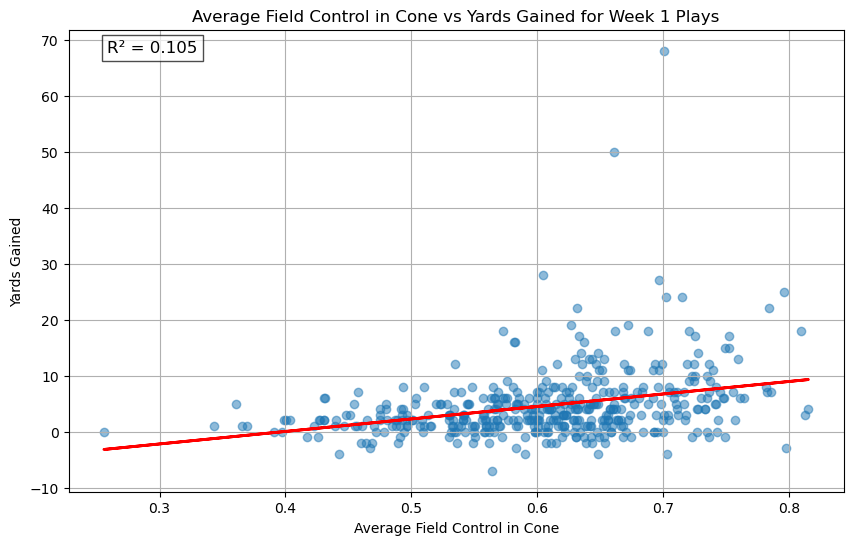

In [ ]:
# plot the relationship
import matplotlib.pyplot as plt

plays_wk1 = plays.merge(
    pd.DataFrame.from_dict(play_results, orient='index', columns=['avg_field_control_in_cone']),
    left_on='game_play_id',
    right_index=True,
    how='left'
).dropna(subset=['avg_field_control_in_cone'])

x = 'avg_field_control_in_cone'

plt.figure(figsize=(10, 6))
plt.scatter(plays_wk1[x], plays_wk1['yards_gained'], alpha=0.5)
# best fit line
m, b = np.polyfit(plays_wk1[x], plays_wk1['yards_gained'], 1)
plt.plot(plays_wk1[x], m * plays_wk1[x] + b, color='red', linewidth=2, label='Best Fit Line')
# plot r squared
r2  v
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('Average Field Control in Cone vs Yards Gained for Week 1 Plays')
plt.xlabel('Average Field Control in Cone')
plt.ylabel('Yards Gained')
plt.grid()
plt.show()

In [33]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(plays_wk1['avg_field_control_in_cone'], plays_wk1['yards_gained'])
print(f"p-value: {p_value:.9f}")

p-value: 0.000000000


# 6. Use the leave-one-out approach for O-Line Attribution 

# NOTE: this takes a long time to run
Took 6 hrs to run on my Macbook Air. You can also load the output data in one of the successive notebook cells from `oline_attribution_results.csv`

In [35]:
import numpy as np
from matplotlib.path import Path
from tqdm import tqdm

def calculate_oline_attribution(game_play_id, cone_granularity=0.5):
    """Calculate O-line attribution using leave-one-out approach"""
    df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
    frame_ids = sorted(df_all['frame_id'].unique())
    
    # Get O-line players (assuming position_by_loc identifies them)
    oline = df_all[df_all['position_by_loc'].isin(['LG','LT','C','RG','RT'])].copy()
    if len(oline) < 5:
        return None  # Skip plays with missing O-line data
    
    oline_ids = oline['nfl_id'].unique()
    
    # Calculate baseline (all O-line present)
    baseline_fc = calculate_play_fc(df_all, frame_ids, cone_granularity)
    
    # Calculate leave-one-out scenarios
    results = {}
    for excluded_id in oline_ids:
        modified_df = df_all[df_all['nfl_id'] != excluded_id]
        loo_fc = calculate_play_fc(modified_df, frame_ids, cone_granularity)
        results[excluded_id] = baseline_fc - loo_fc  # Positive = worse without this player
    
    return {
        'game_play_id': game_play_id,
        'baseline_fc': baseline_fc,
        'attributions': results,
        'oline_positions': dict(zip(oline_ids, oline.groupby('nfl_id')['position_by_loc'].first()))
    }

def calculate_play_fc(df, frame_ids, cone_granularity):
    """Helper function to calculate field control for a modified dataframe"""
    fc_values = []
    
    for frame_id in frame_ids:
        frame_df = df[df['frame_id'] == frame_id]
        rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
        
        if not rb_data.empty:
            rb = rb_data.iloc[0]
            rb_pos = np.array([rb.x, rb.y])
            rb_dir_rad = rb.dir * np.pi / 180
            rb_speed = rb.s
            
            cone_vertices = get_vision_cone(rb_pos, rb_dir_rad, rb_speed)
            path = Path(cone_vertices)
            
            # Create high-resolution grid for cone area
            x_min, x_max = cone_vertices[:,0].min()-2, cone_vertices[:,0].max()+2
            y_min, y_max = cone_vertices[:,1].min()-2, cone_vertices[:,1].max()+2
            
            X, Y, coords = create_cone_grid(x_min, x_max, y_min, y_max, cone_granularity)
            cone_coords = coords[path.contains_points(coords)]
            
            if len(cone_coords) > 0:
                fc = calculate_frame_fc(frame_df, cone_coords)
                fc_values.append(fc)
    
    return np.mean(fc_values) if fc_values else 0

def calculate_frame_fc(frame_df, cone_coords):
    """Calculate field control for a single frame"""
    fc_values = np.zeros(len(cone_coords))
    cols = ['x','y','s','dir','offense','euclidean_dist_to_ball_carrier','engaged',
            'x_closest_off_player','y_closest_off_player']
    
    for i, coord in enumerate(cone_coords):
        for row in frame_df[cols].itertuples(index=False):
            fc_values[i] += influence(
                p=coord,
                p_i=np.array([row.x, row.y]),
                s=row.s + sys.float_info.epsilon,
                theta=row.dir * np.pi / 180,
                rb_dist=row.euclidean_dist_to_ball_carrier,
                is_offense=row.offense
            )
    
    return np.mean(1 / (1 + np.exp(-fc_values)))

def create_cone_grid(x_min, x_max, y_min, y_max, granularity):
    """Create coordinate grid for cone area"""
    X = np.arange(x_min, x_max + granularity, granularity)
    Y = np.arange(y_min, y_max + granularity, granularity)
    X, Y = np.meshgrid(X, Y)
    coords = np.column_stack([X.ravel(), Y.ravel()])
    return X, Y, coords

# Process all plays and save results
attribution_results = []
for game_play_id in tqdm(tracking['game_play_id'].unique(), 
                         desc='Evaluating O-line Attribution'):
    result = calculate_oline_attribution(game_play_id)
    if result:  # Only include plays with complete O-line
        attribution_results.append(result)

# Convert to DataFrame for analysis
attrib_df = pd.DataFrame([
    {
        'game_play_id': res['game_play_id'],
        'player_id': pid,
        'position': res['oline_positions'][pid],
        'fc_attribution': val,
        'baseline_fc': res['baseline_fc']
    }
    for res in attribution_results
    for pid, val in res['attributions'].items()
])

Evaluating O-line Attribution: 100%|██████████| 3623/3623 [6:02:14<00:00,  6.00s/it]  


In [37]:
attrib_df.to_csv('oline_attribution_results.csv', index=False)

In [24]:
attrib_df = pd.read_csv('oline_attribution_results.csv')

In [25]:
attrib_df.head()

game_play_id  player_id position  fc_attribution  baseline_fc
0  2022091200_64    41310.0       RG        0.064242      0.55749
1  2022091200_64    43537.0        C        0.017661      0.55749
2  2022091200_64    47907.0       LG        0.014740      0.55749
3  2022091200_64    54474.0       LT        0.000685      0.55749
4  2022091200_64    54537.0       RT        0.021895      0.55749

In [26]:
ol_attrib = (
    attrib_df.merge(
        players[['nfl_id', 'display_name','position']],
        left_on='player_id',
        right_on='nfl_id',
        how='left',
        suffixes=('', '_roster')
    ).groupby('player_id').aggregate({
        'display_name': 'first',
        'position_roster': 'first',
        'fc_attribution': 'mean',
        'position': 'count',
    }).reset_index().sort_values('fc_attribution', ascending=False).rename(columns={
        'position': 'n_plays',
    }).query('n_plays > 80').reset_index(drop=True)
)

ol_attrib.head()

player_id      display_name position_roster  fc_attribution  n_plays
0    37266.0       Jason Kelce               C        0.071217       89
1    44870.0       Ethan Pocic               C        0.070674      157
2    52590.0    Michael Onwenu               G        0.070294      128
3    43307.0        Ryan Kelly               C        0.070024      109
4    53466.0  Landon Dickerson               G        0.069889       85

In [27]:
ol_attrib.fc_attribution.describe()

count    119.000000
mean       0.055023
std        0.008221
min        0.037702
25%        0.049169
50%        0.054207
75%        0.061030
max        0.071217
Name: fc_attribution, dtype: float64

In [28]:
ol_attrib = (
    ol_attrib.assign(
        fc_attribution_rescaled=lambda x: (
            x.fc_attribution - x.fc_attribution.min() + 0.005
        ) / (x.fc_attribution.max() - x.fc_attribution.min() + 0.005) *.98
    )
)

# 7. Validate results with all pro history

In [29]:
import nfl_data_py as nfl

cols = ['season','pfr_player_name','category','position','allpro','seasons_started','w_av','games']
allpros = (
    nfl.import_draft_picks(years=range(2000,2023))
    .query('category == "OL"')
    [cols]
    .merge(
        nfl.import_seasonal_rosters([2022])
        .query('position == "OL"')
        [['player_name','rookie_year','gsis_it_id','headshot_url']],
        left_on=['pfr_player_name', 'season'],
        right_on=['player_name', 'rookie_year'],
        how='left'
    )
    .assign(
        gsis_it_id=lambda x: x['gsis_it_id'].astype('float'),
    )
)

allpros.head()

season   pfr_player_name category position  allpro  seasons_started  w_av  \
0    2000     Chris Samuels       OL        T     0.0              9.0  63.0   
1    2000  Stockar McDougle       OL        T     0.0              3.0  23.0   
2    2000    Chris McIntosh       OL        T     0.0              1.0   8.0   
3    2000   Travis Claridge       OL        G     0.0              3.0  23.0   
4    2000      Marvel Smith       OL        T     0.0              7.0  44.0   

   games player_name  rookie_year  gsis_it_id headshot_url  
0  141.0         NaN          NaN         NaN          NaN  
1   81.0         NaN          NaN         NaN          NaN  
2   24.0         NaN          NaN         NaN          NaN  
3   52.0         NaN          NaN         NaN          NaN  
4  111.0         NaN          NaN         NaN          NaN

#### Impute the missing performance data

In [30]:
player_data = {
    "Shaquille Mason": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 67,
        "games": 147
    },
    "Nate Herbig": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 13,
        "games": 61
    },
    "David Andrews": {
        "allpro": 0,
        "seasons_started": 9,
        "w_av": 58,
        "games": 124
    },
    "Evan Brown": {
        "allpro": 0,
        "seasons_started": 6,
        "w_av": 23,
        "games": 74
    },
    "Andrew Norwell": {
        "allpro": 1,
        "seasons_started": 9,
        "w_av": 63,
        "games": 128
    },
    "Matt Feiler": {
        "allpro": 0,
        "seasons_started": 7,
        "w_av": 47,
        "games": 91
    },
    "Aaron Brewer": {
        "allpro": 0,
        "seasons_started": 3,
        "w_av": 15,
        "games": 75
    },
    "Elijah Wilkinson": {
        "allpro": 0,
        "seasons_started": 6,
        "w_av": 27,
        "games": 79
    },
    "La'el Collins": {
        "allpro": 0,
        "seasons_started": 7,
        "w_av": 52,
        "games": 89
    },
    "Terence Steele": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 28,
        "games": 79
    },
    "Lloyd Cushenberry": {
        "allpro": 0,
        "seasons_started": 4,
        "w_av": 22,
        "games": 65
    },
    "Sam Mustipher": {
        "allpro": 0,
        "seasons_started": 4,
        "w_av": 18,
        "games": 64
    },
    "Alaric Jackson": {
        "allpro": 0,
        "seasons_started": 4,
        "w_av": 12,
        "games": 41
    },
    "Jon Runyan": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 34,
        "games": 80
    },
    "Charles Leno": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 69,
        "games": 149
    },
    "Jake Brendel": {
        "allpro": 0,
        "seasons_started": 7,
        "w_av": 20,
        "games": 88
    },
    "Jedrick Wills": {
        "allpro": 0,
        "seasons_started": 5,
        "w_av": 30,
        "games": 58
    },
    "James Hurst": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 55,
        "games": 150
    },
    "Trenton Brown": {
        "allpro": 0,
        "seasons_started": 10,
        "w_av": 47,
        "games": 103
    }
}
allpro_missing_vals = pd.DataFrame.from_dict(player_data, orient='index').reset_index().rename(columns={
    'index': 'player_name'
})
allpro_missing_vals

player_name  allpro  seasons_started  w_av  games
0     Shaquille Mason       0               10    67    147
1         Nate Herbig       0                5    13     61
2       David Andrews       0                9    58    124
3          Evan Brown       0                6    23     74
4      Andrew Norwell       1                9    63    128
5         Matt Feiler       0                7    47     91
6        Aaron Brewer       0                3    15     75
7    Elijah Wilkinson       0                6    27     79
8       La'el Collins       0                7    52     89
9      Terence Steele       0                5    28     79
10  Lloyd Cushenberry       0                4    22     65
11      Sam Mustipher       0                4    18     64
12     Alaric Jackson       0                4    12     41
13         Jon Runyan       0                5    34     80
14       Charles Leno       0               10    69    149
15       Jake Brendel       0                7    20     88
16      Jedrick Wills       0                5    30     58
17        James Hurst       0               10    55    150
18      Trenton Brown       0               10    47    103

In [31]:
ol_attrib_final = (
    ol_attrib.merge(
        allpros[['gsis_it_id','allpro','seasons_started','w_av','games','headshot_url']],
        left_on='player_id',
        right_on='gsis_it_id',
        how='left',
    )
    .drop(columns=['gsis_it_id'])
    .merge(
        allpro_missing_vals,
        left_on='display_name',
        right_on='player_name',
        how='left',
        suffixes=('', '_missing')
    )
    .assign(
        allpro=lambda x: x['allpro'].fillna(x['allpro_missing']),
        seasons_started=lambda x: x['seasons_started'].fillna(x['seasons_started_missing']),
        w_av=lambda x: x['w_av'].fillna(x['w_av_missing']),
        games=lambda x: x['games'].fillna(x['games_missing'])
    )
    .drop(columns=['allpro_missing', 'seasons_started_missing', 'w_av_missing', 'games_missing','player_name'])
    .assign(
        allpro_rate=lambda x: x['allpro'] / x['seasons_started']
    )
    .assign(
        allpro_rate=lambda x: x['allpro_rate'].fillna(0),
    )
)
ol_attrib_final.head()

player_id      display_name position_roster  fc_attribution  n_plays  \
0    37266.0       Jason Kelce               C        0.071217       89   
1    44870.0       Ethan Pocic               C        0.070674      157   
2    52590.0    Michael Onwenu               G        0.070294      128   
3    43307.0        Ryan Kelly               C        0.070024      109   
4    53466.0  Landon Dickerson               G        0.069889       85   

   fc_attribution_rescaled  allpro  seasons_started   w_av  games  \
0                 0.980000     6.0             12.0  102.0  193.0   
1                 0.966191     0.0              4.0   30.0  101.0   
2                 0.956513     0.0              4.0   26.0   81.0   
3                 0.949643     0.0              9.0   54.0  121.0   
4                 0.946203     0.0              4.0   31.0   63.0   

                                        headshot_url  allpro_rate  
0  https://static.www.nfl.com/image/private/f_aut...          0.5  
1  https://static.www.nfl.com/image/private/f_aut...          0.0  
2  https://static.www.nfl.com/image/private/f_aut...          0.0  
3  https://static.www.nfl.com/image/private/f_aut...          0.0  
4  https://static.www.nfl.com/image/private/f_aut...          0.0

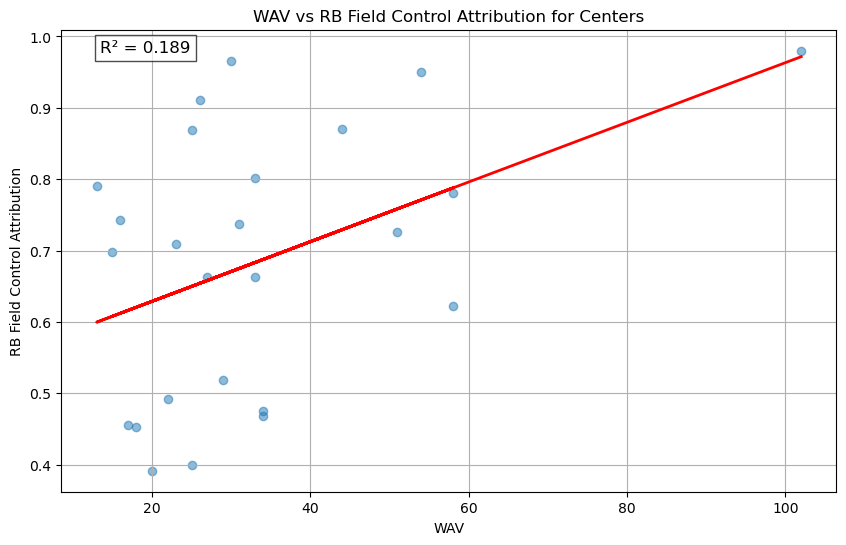

In [32]:
position = 'C'
grouped_attrib = ol_attrib_final.query('position_roster == @position')
plt.figure(figsize=(10, 6))
plt.scatter(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], alpha=0.5)
r2 = np.corrcoef(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'])[0, 1] ** 2
plt.plot(grouped_attrib['w_av'], np.poly1d(np.polyfit(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], 1))(grouped_attrib['w_av']), color='red', linewidth=2, label='Best Fit Line')
# plot r squared
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('WAV vs RB Field Control Attribution for Centers')
plt.xlabel('WAV')
plt.ylabel('RB Field Control Attribution')
plt.grid()

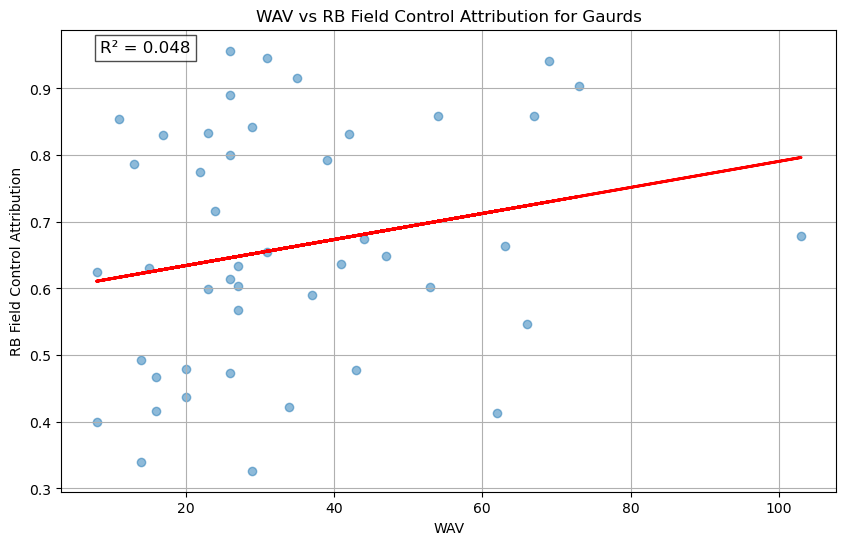

In [33]:
position = 'G'
grouped_attrib = ol_attrib_final.query('position_roster == @position')
plt.figure(figsize=(10, 6))
plt.scatter(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], alpha=0.5)
r2 = np.corrcoef(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'])[0, 1] ** 2
plt.plot(grouped_attrib['w_av'], np.poly1d(np.polyfit(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], 1))(grouped_attrib['w_av']), color='red', linewidth=2, label='Best Fit Line')
# plot r squared
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('WAV vs RB Field Control Attribution for Gaurds')
plt.xlabel('WAV')
plt.ylabel('RB Field Control Attribution')
plt.grid()

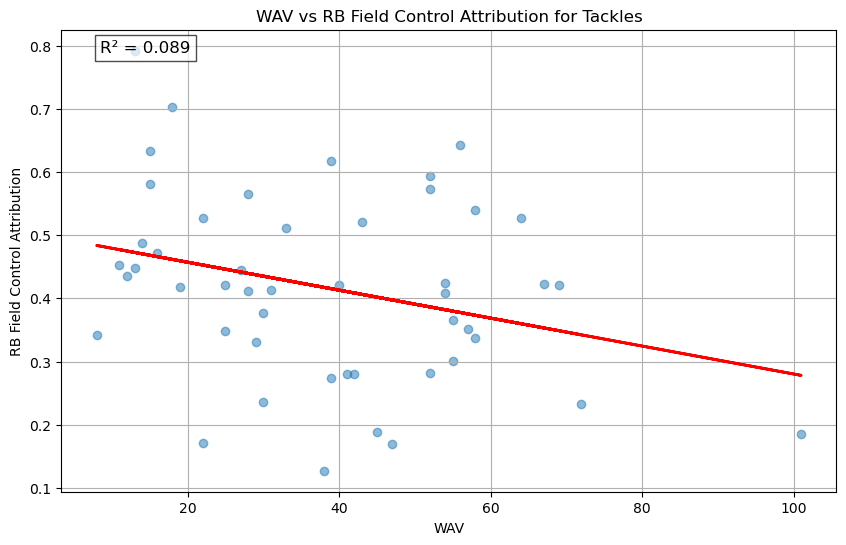

In [34]:
position = 'T'
grouped_attrib = ol_attrib_final.query('position_roster == @position')
plt.figure(figsize=(10, 6))
plt.scatter(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], alpha=0.5)
r2 = np.corrcoef(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'])[0, 1] ** 2
plt.plot(grouped_attrib['w_av'], np.poly1d(np.polyfit(grouped_attrib['w_av'], grouped_attrib['fc_attribution_rescaled'], 1))(grouped_attrib['w_av']), color='red', linewidth=2, label='Best Fit Line')
# plot r squared
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('WAV vs RB Field Control Attribution for Tackles')
plt.xlabel('WAV')
plt.ylabel('RB Field Control Attribution')
plt.grid()

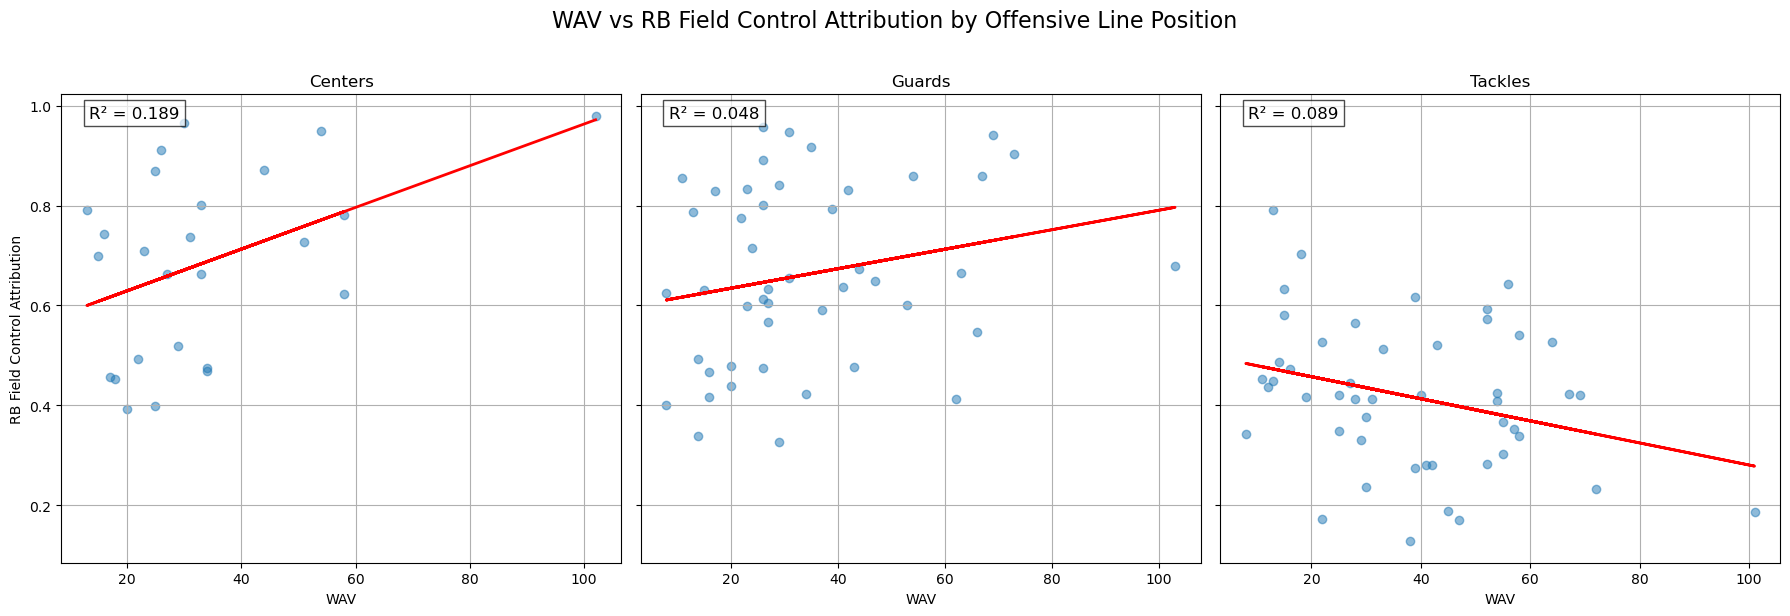

In [35]:
import matplotlib.pyplot as plt
import numpy as np

positions = ['C', 'G', 'T']
position_names = {'C': 'Centers', 'G': 'Guards', 'T': 'Tackles'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, position in zip(axes, positions):
    grouped_attrib = ol_attrib_final.query('position_roster == @position')
    x = grouped_attrib['w_av']
    y = grouped_attrib['fc_attribution_rescaled']
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.5)
    
    # Best fit line
    coeffs = np.polyfit(x, y, 1)
    fit_line = np.poly1d(coeffs)(x)
    ax.plot(x, fit_line, color='red', linewidth=2, label='Best Fit Line')
    
    # R² calculation
    r2 = np.corrcoef(x, y)[0, 1] ** 2
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(position_names[position])
    ax.set_xlabel('WAV')
    if position == 'C':
        ax.set_ylabel('RB Field Control Attribution')
    ax.grid(True)

fig.suptitle('WAV vs RB Field Control Attribution by Offensive Line Position', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# 8. Save the data

In [281]:
cols = ['display_name','w_av','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'w_av': 'WAV',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
(
    ol_attrib_final.query('position_roster == "C"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        WAV=lambda x: x['WAV'].round(0),
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
).to_csv('center_attribution.csv', index=False)

In [282]:
cols = ['display_name','w_av','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'w_av': 'WAV',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
(
    ol_attrib_final.query('position_roster == "G"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        WAV=lambda x: x['WAV'].round(0),
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
).to_csv('gaurd_attribution.csv', index=False)

In [283]:
cols = ['display_name','w_av','n_plays','fc_attribution_rescaled']
rename_dict = {
    'display_name': 'Player',
    'w_av': 'WAV',
    'n_plays': 'N Plays',
    'fc_attribution_rescaled': 'FCA'
}
(
    ol_attrib_final.query('position_roster == "T"')
    [cols]
    .rename(columns=rename_dict)
    .assign(
        FCA=lambda x: x['FCA'].round(3) * 100,
        WAV=lambda x: x['WAV'].round(0),
        N_Plays=lambda x: x['N Plays'].astype(int)
    )
    .rename(columns={
        'N Plays': 'N Plays',
    })
    .drop(columns=['N_Plays'])
    .sort_values('FCA', ascending=False)
).to_csv('tackle_attribution.csv', index=False)